### Network Inversion for Uncertainty-Aware Out-of-Distribution Detection

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))   # For grayscale images (MNIST, FMNIST)
])

### Datasets

In [ ]:
# MNIST Dataset
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# FashionMNIST Dataset
fmnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fmnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
from torch.utils.data import ConcatDataset

full_mnist = ConcatDataset([mnist_train, mnist_test])
full_fmnist = ConcatDataset([fmnist_train, fmnist_test])

In [ ]:
from torch.utils.data import TensorDataset
mnist_images = torch.stack([img for img, _ in full_mnist])
mnist_labels = torch.tensor([label for _, label in full_mnist], dtype=torch.long)
mnist_dataset = TensorDataset(mnist_images, mnist_labels)

In [ ]:
from torch.utils.data import TensorDataset

def map_labels_to_garbage(dataset, garbage_label=10):

    images, labels = [], []
    for img, _ in dataset:
        images.append(img)
        labels.append(garbage_label)
    images = torch.stack(images)
    labels = torch.tensor(labels, dtype=torch.long)
    return TensorDataset(images, labels)

In [ ]:
ood_test_dataset = map_labels_to_garbage(full_fmnist, garbage_label=10)

### Gaussian Noise Samples for Garbage Class

In [ ]:
from torch.utils.data import DataLoader

# Parameters for noise generation
num_noise_samples = 7000
channels, height, width = 1, 28, 28

# Generate Gaussian noise samples (standard normal distribution)
noise_samples = torch.randn(num_noise_samples, channels, height, width)

# Create labels for these noise samples (all set to 10, the garbage class)
garbage_labels = torch.full((num_noise_samples,), 10, dtype=torch.long)

# Create a dataset for the noise samples
noise_dataset = TensorDataset(noise_samples, garbage_labels)

# Combine the full MNIST dataset with the noise dataset
combined_mnist = ConcatDataset([mnist_dataset, noise_dataset])

In [ ]:
# print dataset sizes for verification
print("Full MNIST size:", len(full_mnist))
print("Noise dataset size:", len(noise_dataset))
print("Combined MNIST size:", len(combined_mnist))

Full MNIST size: 70000
Noise dataset size: 7000
Combined MNIST size: 77000


In [ ]:
# Create a DataLoader for the combined dataset
batch_size = 64
train_loader = DataLoader(combined_mnist, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(ood_test_dataset, batch_size=batch_size, shuffle=False)

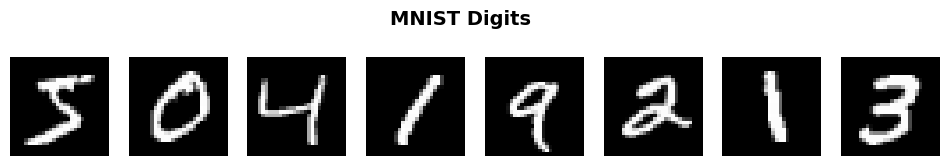

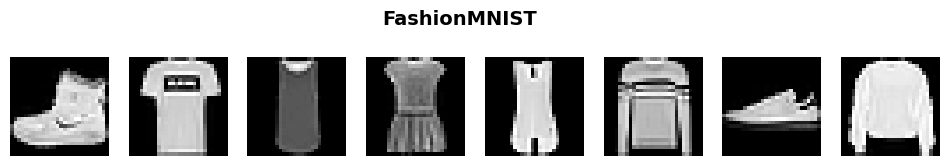

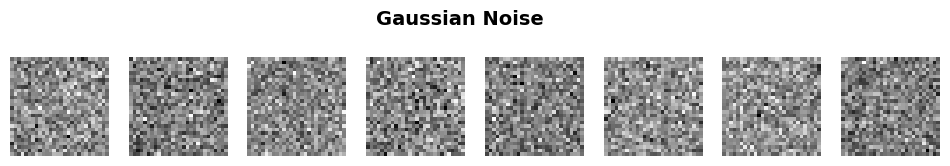

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples per dataset
num_samples = 8

# Select samples from each dataset
mnist_images, _ = zip(*[full_mnist[i] for i in range(num_samples)])
fmnist_images, _ = zip(*[full_fmnist[i] for i in range(num_samples)])
noise_images, _ = zip(*[noise_dataset[i] for i in range(num_samples)])

# Convert tensors to NumPy arrays
mnist_images = [img.numpy() for img in mnist_images]
fmnist_images = [img.numpy() for img in fmnist_images]
noise_images = [img.numpy() for img in noise_images]

# Function to plot images for a given dataset
def plot_images(images, title):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 2))
    for i in range(num_samples):
        axes[i].imshow(images[i][0], cmap="gray")  # Grayscale image
        axes[i].axis("off")
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.show()

# Plot each dataset separately
plot_images(mnist_images, "MNIST Digits")
plot_images(fmnist_images, "FashionMNIST")
plot_images(noise_images, "Gaussian Noise")

# Classifier

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define the extended CNN that outputs 11 classes

class ExtendedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ExtendedCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1   = nn.Linear(64 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        # num_classes + 1 for garbage class (i.e., 11 outputs)
        self.fc2   = nn.Linear(128, num_classes + 1)

    def forward(self, x):
      # Convolutional layers + pooling
      x = F.leaky_relu(self.bn1(self.conv1(x)))
      x = self.pool(x)
      x = F.leaky_relu(self.bn2(self.conv2(x)))
      x = self.pool(x)

      # Flatten
      x = x.view(x.size(0), -1)

      # Penultimate layer: fc1 and dropout
      features = F.leaky_relu(self.fc1(x))
      features = self.dropout(features)

      # Final logits
      logits = self.fc2(features)

      return logits, features

In [ ]:
# Set up device, instantiate model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ExtendedCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device

device(type='cuda')

In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Directory in Google Drive to store checkpoints
checkpoint_dir = "/content/drive/MyDrive/OOD_RnD"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
import os
import torch
import torch.nn.functional as F

def train_classifier(train_loader,  checkpoint_dir, num_epochs=5,):

    train_losses = []
    train_accuracies = []

    # Ensure checkpoint directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits, features = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
             }, checkpoint_path)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    return model, train_losses, train_accuracies

In [ ]:
model , train_losses, train_acc = train_classifier(train_loader, checkpoint_dir, num_epochs=5)

Epoch [1/5] - Loss: 0.1615, Accuracy: 95.06%
Epoch [2/5] - Loss: 0.0670, Accuracy: 97.99%
Epoch [3/5] - Loss: 0.0518, Accuracy: 98.43%
Epoch [4/5] - Loss: 0.0418, Accuracy: 98.68%
Epoch [5/5] - Loss: 0.0360, Accuracy: 98.90%


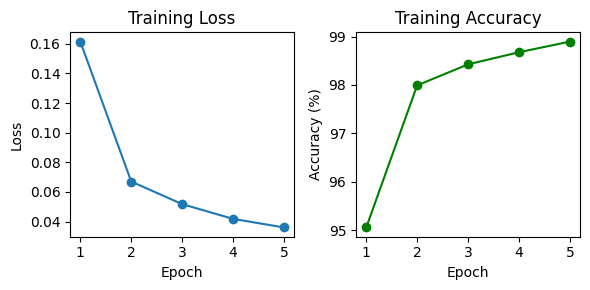

In [ ]:
num_epochs = 5
# Plot Loss and Accuracy curves
epochs = range(1, num_epochs+1)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epochs, train_acc , marker='o', color='green')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.tight_layout()
plt.show()

In [ ]:
def test_classifier(test_loader, model, criterion, device):

    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits, features = model(images)
            loss = criterion(logits, labels)
            running_loss += loss.item()

            # Get predictions and update correct counts
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc

In [ ]:
test_loss, test_acc = test_classifier(test_loader, model, criterion, device)

Test Loss: 7.9202, Test Accuracy: 3.35%


In [ ]:
# Function to find the latest checkpoint
def find_latest_checkpoint(checkpoint_dir):
    # List all files in the checkpoint directory
    checkpoint_files = os.listdir(checkpoint_dir)

    # Filter files that match the checkpoint pattern (e.g., checkpoint_epoch_X.pt)
    checkpoint_files = [f for f in checkpoint_files if f.startswith("checkpoint_epoch_") and f.endswith(".pt")]

    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found in the directory.")

    # Extract epoch numbers from filenames
    epoch_numbers = [int(re.search(r"checkpoint_epoch_(\d+).pt", f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint = f"checkpoint_epoch_{latest_epoch}.pt"
    latest_checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

    return latest_checkpoint_path

Loading latest checkpoint: /content/drive/MyDrive/OOD_RnD/checkpoint_epoch_5.pt


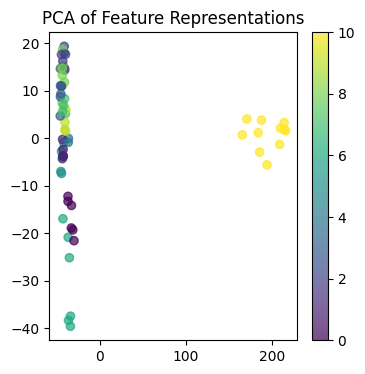

In [ ]:
import re

# Find and load the latest checkpoint
latest_checkpoint_path = find_latest_checkpoint(checkpoint_dir)
print(f"Loading latest checkpoint: {latest_checkpoint_path}")

# Load the model
model_with_features = ExtendedCNN(num_classes=10).to(device)
checkpoint = torch.load(latest_checkpoint_path, map_location=device,weights_only=True)
model_with_features.load_state_dict(checkpoint['model_state_dict'])
model_with_features.eval()

# Get a batch of images
images, labels = next(iter(train_loader))
images = images.to(device)

# Forward pass to get features
with torch.no_grad():
    logits, features = model_with_features(images)

# Move features to CPU and convert to numpy
features_np = features.cpu().numpy()
labels_np = labels.cpu().numpy()

# PCA to visualize these features
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_np)

plt.figure(figsize=(4, 4))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("PCA of Feature Representations")
plt.show()

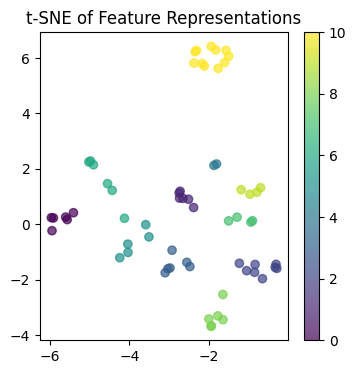

In [ ]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce features to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
features_2d_tsne = tsne.fit_transform(features_np)

plt.figure(figsize=(4,4))
scatter = plt.scatter(features_2d_tsne[:, 0], features_2d_tsne[:, 1], c=labels_np, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title("t-SNE of Feature Representations")
plt.show()

# Generator

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InversionGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, image_size):
        super(InversionGenerator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.image_size = image_size

        # Fully connected layer to map the concatenated latent vector and conditioning vector
        # The input dimension is latent_dim + num_classes
        # Map this to a feature map that can be reshaped to (128, 7, 7)
        self.fc = nn.Linear(latent_dim + num_classes, 128 * 7 * 7)

        # Upsampling blocks: Combination of Upsample, Conv2d, BatchNorm, and ReLU
        # The final image is produced with a Tanh activation to output pixel values in [-1, 1]
        self.up_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # transforms 7x7 -> 14x14
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),   # can use leaky relu

            nn.Upsample(scale_factor=2),  # transforms 14x14 -> 28x28
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()  # outputs in range [-1, 1]
        )

    def forward(self, z, cond):

        # Concatenate the latent vector and conditioning vector
        x = torch.cat([z, cond], dim=1)   # Shape: [B, latent_dim + num_classes]

        # Map the combined vector to a feature map and reshape it to 4D
        x = self.fc(x)                    # Shape: [B, 128 * 7 * 7]
        x = x.view(-1, 128, 7, 7)         # Reshape to [B, 128, 7, 7]

        # Upsample the feature map to the final image size
        out = self.up_blocks(x)           # Shape: [B, 1, 28, 28]
        return out

In [ ]:
latent_dim = 100
num_classes = 10
generator = InversionGenerator(latent_dim, num_classes, image_size=28)

In [ ]:
# Generate a random latent vector and a random conditioning vector
batch_size = 500
z = torch.randn(batch_size, latent_dim)

# For conditioning: generate random values then apply softmax to simulate a distribution
cond_raw = torch.randn(batch_size, num_classes)
cond_dist = F.softmax(cond_raw, dim=1)

# Generate images
gen_images = generator(z, cond_dist)
print("Generated images shape:", gen_images.shape)  # Should be [500, 1, 28, 28]

Generated images shape: torch.Size([500, 1, 28, 28])


In [ ]:
def generate_images(batch_size):

  z = torch.randn(batch_size, latent_dim)

  # For conditioning: generate random values then apply softmax to simulate a distribution
  cond_raw = torch.randn(batch_size, num_classes)
  cond_dist = F.softmax(cond_raw, dim=1)

  # Generate images
  gen_images = generator(z, cond_dist)

  return gen_images

In [ ]:
def update_dataset(gen_images, current_dataset, batch_size):

    # Check if there are any generated images
    if gen_images is None or gen_images.size(0) == 0:
        print("Warning: No generated images provided for dataset update.")
        return current_dataset, DataLoader(current_dataset, batch_size=batch_size, shuffle=True)

    # Move generated images and labels to CPU
    gen_images = gen_images.cpu()  # Move images to CPU
    num_gen_samples = gen_images.size(0)
    gen_labels = torch.full((num_gen_samples,), 10, dtype=torch.long)  # Labels are already on CPU

    # Create a dataset for the generated samples
    gen_dataset = TensorDataset(gen_images, gen_labels)

    # Combine the existing dataset with the new generated dataset
    updated_dataset = ConcatDataset([current_dataset, gen_dataset])

    # Recreate the DataLoader for the updated dataset
    train_loader = DataLoader(updated_dataset, batch_size=batch_size, shuffle=True)

    return updated_dataset, train_loader

# Losses

In [ ]:
from collections import Counter
import torch
import torch.nn.functional as F

# Precompute counts for in-distribution classes (0 to 9) from full MNIST
in_dist_labels = [label for _, label in mnist_dataset]  # mnist_dataset from your earlier code
in_dist_counts = Counter([label.item() for label in in_dist_labels])

for i in range(10):
  print(f"class {i}:{in_dist_counts[i]}")

class 0:6903
class 1:7877
class 2:6990
class 3:7141
class 4:6824
class 5:6313
class 6:6876
class 7:7293
class 8:6825
class 9:6958


In [ ]:
from collections import Counter
import torch

def compute_dynamic_weights(static_counts, current_dataset, num_classes=11, device='cuda'):

  # Count occurrences of each label in the current dataset
  all_labels = [label.item() for _, label in current_dataset]
  total_counts = Counter(all_labels)

  # Initialize updated counts
  updated_counts = {i: static_counts.get(i, 1) for i in range(10)}  # Ensure all classes (0-9) exist
  updated_counts[10] = total_counts.get(10, 1)  # Avoid KeyError for class 10 (garbage)

  # Compute weights
  total_samples = sum(updated_counts.values())
  weights = [total_samples / (num_classes * max(updated_counts[i], 1)) for i in range(num_classes)]  # Avoid division by zero

  # Convert to PyTorch tensor
  weights = torch.tensor(weights, dtype=torch.float, device=device)

  return weights


In [ ]:
def weighted_cross_entropy(current_dataset, logits, target_labels):

  dynamic_weights = compute_dynamic_weights(in_dist_counts, current_dataset, num_classes=11, device=device)
  ce_loss = F.cross_entropy(logits, target_labels, weight=dynamic_weights)

  return ce_loss

In [ ]:
def kl_divergence(logits, cond_dist):

    q_dist = F.softmax(logits, dim=1)  # [B, 11]
    num_classes = cond_dist.size(1)
    q_sliced = q_dist[:, :num_classes]  # [B, num_classes]
    kl_loss = torch.sum(cond_dist * torch.log((cond_dist + 1e-8) / (q_sliced + 1e-8)), dim=1).mean()
    return kl_loss

In [ ]:
def cosine_similarity(features):

  # Normalize features so that cosine similarity equals the dot product.
  normalized_features = F.normalize(features, p=2, dim=1)  # [B, D]
  # Compute cosine similarity matrix: [B, B]
  cos_sim_matrix = torch.matmul(normalized_features, normalized_features.t())
  B = features.size(0)
  # Exclude diagonal elements (self-similarity)
  mask = torch.ones_like(cos_sim_matrix) - torch.eye(B, device=cos_sim_matrix.device)
  cos_sim_sum = torch.sum(cos_sim_matrix * mask)
  num_pairs = B * (B - 1)
  cos_loss = cos_sim_sum / (num_pairs + 1e-8)

  return cos_loss

In [ ]:
def feature_orthogonality(features):

  B = features.size(0)
  G = torch.matmul(features, features.t())  # [B, B]
  I = torch.eye(B, device=features.device)
  ortho_loss = F.mse_loss(G, I)
  return ortho_loss

In [ ]:
def compute_inversion_loss(gen_imgs,current_dataset, target_labels, cond_dist, model, alpha, beta, gamma, delta):

    logits, features = model(gen_imgs)
    ce_loss = weighted_cross_entropy(current_dataset, logits, target_labels)
    kl_loss = kl_divergence(logits, cond_dist)
    cos_loss = cosine_similarity(features)
    ortho_loss = feature_orthogonality(features)

    total_loss = alpha * kl_loss + beta * ce_loss + gamma * cos_loss + delta * ortho_loss
    return total_loss, (ce_loss, kl_loss, cos_loss, ortho_loss)

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

# Hyperparameters for the inversion loss components
alpha = 1.0   # Weight for KL divergence loss
beta  = 1.0   # Weight for cross-entropy loss
gamma = 1.0   # Weight for cosine similarity loss
delta = 1.0   # Weight for feature orthogonality loss

latent_dim = 100
num_classes = 10  # Conditioning only on in-distribution classes
batch_size = 10
num_iterations = 11  # Total training iterations for the generator

optimizer_gen = optim.Adam(generator.parameters(), lr=0.001)


current_dataset = combined_mnist

# Define checkpoint directory and path
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'latest_model.pt')

# (Optional) Save the initial classifier checkpoint if not already saved
torch.save(model.state_dict(), checkpoint_path)

# Training loop with tqdm progress bar
progress_bar = tqdm(range(num_iterations), desc="Generator Training", unit="step")

for step in progress_bar:
    # Ensure generator is on device and in train mode
    generator.to(device)
    generator.train()

    # 1. Sample a batch of latent vectors z
    z = torch.randn(batch_size, latent_dim, device=device)

    # 2. Generate conditioning vector: sample random values and apply softmax
    cond_raw = torch.randn(batch_size, num_classes, device=device)
    cond_dist = F.softmax(cond_raw, dim=1)  # Shape: [B, num_classes]

    # 3. Derive target labels from conditioning (using argmax)
    target_labels = torch.argmax(cond_dist, dim=1)  # Shape: [B]

    # 4. Generate images using the generator
    gen_imgs = generator(z, cond_dist)  # Expected shape: [B, 1, 28, 28]

    # 5. Load the latest classifier checkpoint and set it to evaluation mode
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()  # Freeze classifier during generator training

    # 6. Compute the combined inversion loss
    total_loss, (ce_loss, kl_loss, cos_loss, ortho_loss) = compute_inversion_loss(
        gen_imgs,current_dataset, target_labels, cond_dist, model, alpha, beta, gamma, delta
    )

    # 7. Backpropagate and update generator parameters
    optimizer_gen.zero_grad()
    total_loss.backward()
    optimizer_gen.step()

    # Update progress bar every 10 steps
    if (step + 1) % 10 == 0:
        progress_bar.set_postfix({
            "Total": total_loss.item(),
            "CE": ce_loss.item(),
            "KL": kl_loss.item(),
            "Cos": cos_loss.item(),
            "Ortho": ortho_loss.item()
        })

    # 8. Update the training dataset with generated images
    # Use detach() to remove the computation graph and move to CPU
    current_dataset, train_loader = update_dataset(gen_imgs.detach().cpu(), current_dataset, batch_size)

    # 9. Retrain (fine-tune) the classifier every 5 iterations
    if step > 0 and step % 5 == 0:
        model, train_losses, train_acc = train_classifier(train_loader, checkpoint_dir, num_epochs=5)

    # 10. Save the updated classifier to checkpoint
    torch.save(model.state_dict(), checkpoint_path)
    print("Classifier checkpoint saved.")

print("Generator training complete.")

Generator Training:   0%|          | 0/11 [00:00<?, ?step/s]<ipython-input-38-db5b2a06e3bd>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.loa

Classifier checkpoint saved.


Generator Training:  18%|█▊        | 2/11 [00:01<00:05,  1.76step/s]

Classifier checkpoint saved.


Generator Training:  27%|██▋       | 3/11 [00:01<00:04,  1.93step/s]

Classifier checkpoint saved.


Generator Training:  36%|███▋      | 4/11 [00:02<00:03,  1.96step/s]

Classifier checkpoint saved.


Generator Training:  45%|████▌     | 5/11 [00:02<00:03,  1.95step/s]

Classifier checkpoint saved.
Epoch [1/5] - Loss: 0.0682, Accuracy: 98.09%
Epoch [2/5] - Loss: 0.0434, Accuracy: 98.76%
Epoch [3/5] - Loss: 0.0376, Accuracy: 98.90%
Epoch [4/5] - Loss: 0.0311, Accuracy: 99.09%


Generator Training:  55%|█████▍    | 6/11 [01:58<03:19, 39.84s/step]

Epoch [5/5] - Loss: 0.0284, Accuracy: 99.19%
Classifier checkpoint saved.


Generator Training:  64%|██████▎   | 7/11 [01:59<01:48, 27.00s/step]

Classifier checkpoint saved.


Generator Training:  73%|███████▎  | 8/11 [01:59<00:55, 18.58s/step]

Classifier checkpoint saved.


Generator Training:  82%|████████▏ | 9/11 [02:00<00:25, 12.95s/step]

Classifier checkpoint saved.


Generator Training:  91%|█████████ | 10/11 [02:01<00:09,  9.13s/step, Total=7.51e+4, CE=25.1, KL=16, Cos=0.974, Ortho=7.51e+4]

Classifier checkpoint saved.
Epoch [1/5] - Loss: 0.0266, Accuracy: 99.24%
Epoch [2/5] - Loss: 0.0245, Accuracy: 99.30%
Epoch [3/5] - Loss: 0.0222, Accuracy: 99.39%
Epoch [4/5] - Loss: 0.0198, Accuracy: 99.42%


Generator Training: 100%|██████████| 11/11 [04:04<00:00, 22.21s/step, Total=7.51e+4, CE=25.1, KL=16, Cos=0.974, Ortho=7.51e+4]

Epoch [5/5] - Loss: 0.0208, Accuracy: 99.42%
Classifier checkpoint saved.
Generator training complete.


In [ ]:
test_loss, test_acc = test_classifier(test_loader, model, criterion, device)
print(f"Test accuracy:{test_acc}")

Test Loss: 2.6739, Test Accuracy: 77.45%
Test accuracy:77.44571428571429
